# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

### Autoreload

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['HW5.ipynb', 'hw_lib']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "DL and AdvAI/HW5"
assert GOOGLE_DRIVE_PATH_AFTER_MYDRIVE is not None
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['__init__.py', 'utils.py', 'rnn.py', 'HW5.ipynb', '__pycache__']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment.
If everything works correctly, you should see
```
Hello Deep Learning
```

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import utils
utils.hello()

Hello Deep Learning


# Fill your UMID and unique name

Now find `um_id()` and `unique_name()` and implement them.
**This is required before turning in your assigments because this makes sure auto-grading system can assign grades correctly to you.**

In [5]:
import utils
my_unique_name = utils.unique_name()
assert my_unique_name is not None
print(f"{my_unique_name=}")

my_unique_name='dharshaa'


In [6]:
import utils
my_um_id = utils.um_id()
assert my_um_id is not None
assert isinstance(my_um_id, str)
assert len(my_um_id) == 8
print(f"{my_um_id=}")

my_um_id='82653870'


# Image Captioning

The objective is to train a CNN + RNN model for image captioning. For a simple example, we’ll use the MNIST dataset, where each image will be captioned as 'This is number X,' with X representing the specific digit in the image

In [7]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

from rnn import set_seed

## Tokenization (20 pts)

First, we need to create a tokenizer to process the captions for each MNIST image. Additionally, we’ll include two special tokens: <START> to mark the beginning and <EOS> to indicate the end of each caption.
```
"<START>", "This",  "is", "number", "<EOS>", "0", "1", "2", ... , "8", "9"
```

In [8]:
import numpy as np
from rnn import Tokenizer
tokenizer = Tokenizer()

# We have 14 tokens as "<START>", "This",  "is", "number", "<EOS>", "0", "1", ... , "8", "9"
expected_vocab_size = 14
vocab_size = len(tokenizer)
np.allclose(expected_vocab_size, vocab_size)

assert '<START>' == tokenizer.idx_to_word[0]
assert '<EOS>' == tokenizer.idx_to_word[1]
assert 'This' == tokenizer.idx_to_word[2]
assert 'is' == tokenizer.idx_to_word[3]
assert 'number' == tokenizer.idx_to_word[4]


assert tokenizer.word_to_idx['<START>'] == 0
assert tokenizer.word_to_idx['<EOS>'] == 1
assert tokenizer.word_to_idx['This'] == 2
assert tokenizer.word_to_idx['is'] == 3
assert tokenizer.word_to_idx['number'] == 4


for num in range(9):
  assert num == tokenizer.word_to_idx[tokenizer.idx_to_word[num]]

s = "This is number 9"
encoded_tokens = tokenizer.encode(s)
expected_encoded_tokens = [0, 2, 3, 4, 14, 1]
decoded_s = tokenizer.decode(encoded_tokens)
print(decoded_s)
assert s == decoded_s

This is number 9


## ImageCaptioningRNN (80 pts)

In this section, we'll construct a neural network model that combines CNN and RNN architectures. For more details, refer to `hw_lib.rnn.ImageCaptioningRNN`.

### Test `ImageCaptioningRNN.cnn` (10 pts)

In [9]:
from rnn import ImageCaptioningRNN

model = ImageCaptioningRNN(vocab_size=len(tokenizer))

random_mnist_array = torch.rand((1, 1, 28, 28)) # Batch x Channel x H x W
cnn_flatten_features = model.cnn(random_mnist_array)
expected_cnn_flatten_features = 32 * 5 * 5
print(cnn_flatten_features.shape)
assert cnn_flatten_features.shape[1] == expected_cnn_flatten_features


torch.Size([1, 800])


### Test `ImageCaptioningRNN.fc` (10 pts)

In [10]:
hidden_init = model.fc(cnn_flatten_features)
print(hidden_init.shape)
expected_hidden_init_shape = torch.Size([1, 32])
assert hidden_init.shape == expected_hidden_init_shape

torch.Size([1, 32])


### Test `ImageCaptioningRNN.embedding` (10 pts)

In [11]:
expected_embedding_shape = torch.Size([1, 64])
for i in range(len(tokenizer)):
    embedding = model.embedding(torch.tensor([i]))
    assert embedding.shape == expected_embedding_shape, f"{embedding.shape} != {expected_embedding_shape}"

### Test `ImageCaptioningRNN()` Model (10 pts)

In [12]:
encoded_token = torch.tensor(tokenizer.encode("This is number 0")).unsqueeze(0)
print(encoded_token.shape) # Batch x NumberOfTokens
output = model(random_mnist_array, encoded_token)
print(output.shape)
expected_ouput_shape = torch.Size([1, 6, 15])
assert output.shape == expected_ouput_shape

torch.Size([1, 6])
torch.Size([1, 6, 15])


### Test `ImageCaptioningRNN` on MNIST before training (10 pts)

In [13]:
# Loading MNIST dataset and setting up a subset
set_seed()
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
subset_indices = random.sample(range(len(mnist_dataset)), 100)
mnist_subset = Subset(mnist_dataset, subset_indices)

# Initialize tokenizer and model
tokenizer = Tokenizer()
model = ImageCaptioningRNN(vocab_size=len(tokenizer))

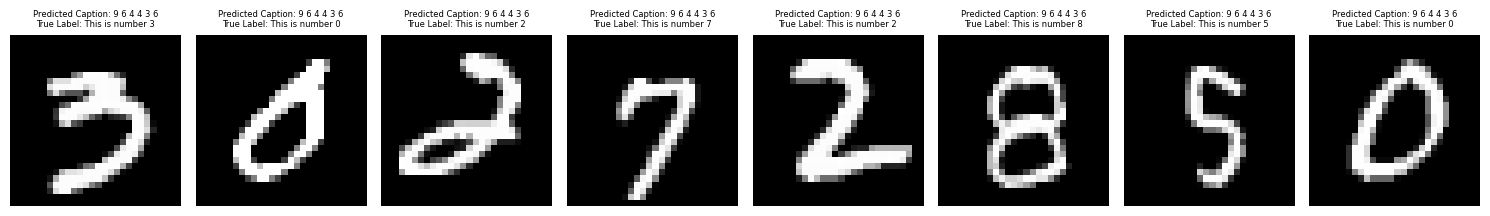

In [14]:
from rnn import evaluate_model
set_seed()
evaluate_model(model, tokenizer, mnist_subset, num_of_eval_images=8)

### Test `generate_caption_labels` (10 pts)

In [15]:
from rnn import generate_caption_labels
batch_size=3
data_loader = DataLoader(mnist_subset, batch_size=batch_size, shuffle=True)
images, labels = next(iter(data_loader))

captions_labels = generate_caption_labels(tokenizer, labels)
print(captions_labels.shape)
expected_captions_labels_shape = torch.Size([batch_size, 6])
assert expected_captions_labels_shape == captions_labels.shape

for i in range(batch_size):
  assert captions_labels[0][0].item() == tokenizer.word_to_idx["<START>"]
  assert captions_labels[0][1].item() == tokenizer.word_to_idx["This"]
  assert captions_labels[0][2].item() == tokenizer.word_to_idx["is"]
  assert captions_labels[0][3].item() == tokenizer.word_to_idx["number"]
  assert captions_labels[0][4].item() == tokenizer.word_to_idx[str(labels[0].item())]
  assert captions_labels[0][5].item() == tokenizer.word_to_idx["<EOS>"]

torch.Size([3, 6])


### Train `ImageCaptioningRNN` on a single MNIST image (10 pts)

In [16]:
from rnn import train
# Initialize tokenizer and model
set_seed()
tokenizer = Tokenizer()
model = ImageCaptioningRNN(vocab_size=len(tokenizer))
loss, outputs, targets = train(model, tokenizer, mnist_subset, num_epochs=2000, batch_size=1, only_train_one_batch=True)

print(f"{loss.detach().numpy()=}")
expected_loss = 2.6720175743103027
assert np.allclose(loss.item(), expected_loss, atol=1e-4)
expected_output = np.array([
    [-0.0327062, 0.00127096, 0.21435786, -0.3020008, -0.25145784, -0.06073475,
     0.2156337, -0.3376511, -0.00976793, 0.12439405, -0.10971967, 0.15858263,
     -0.18457346, -0.8318259, 0.24399355],
    [-0.03072808, 0.02320278, 0.12035577, -0.3231122, -0.09789988, -0.12737629,
     0.03407088, 0.2263392, 0.19223961, 0.16673166, -0.12928834, 0.2667337,
     0.32776046, 0.06415908, 0.9804322],
    [0.22728074, 0.08434436, 0.20842321, -0.08587918, -0.21542875, -0.8325184,
     0.04442584, 0.06238612, 0.11078683, -0.08821327, 0.17117137, 0.11280977,
     -0.15719566, 0.10294621, 0.04085323],
    [-0.18410277, -0.12552996, 0.4543858, 0.14935106, -0.05789977, 0.10132655,
     0.02404967, 0.27602762, 0.3920847, -0.09708437, 0.02568019, -0.2673953,
     0.20486966, -0.21069297, -0.11131455],
    [-0.34078658, 0.04706115, -0.20156106, 0.2994057, 0.06740084, 0.34660777,
     0.03566727, 0.08656936, 0.10872399, 0.23755988, 0.03271667, 0.08856396,
     0.10872399, 0.23755988, 0.10872399]
])

# Convert logits to predicted token indices
predicted_tokens = outputs.argmax(dim=-1)

# What we expect the predicted caption to be: "This is number 9"
# The expected tokens should only include the tokens for the first image.
expected_predicted_tokens = torch.tensor([14])  # token id for: 9

# Assert prediction is as expected
# We are checking the prediction for the first image which corresponds to index 0
assert torch.equal(predicted_tokens[0].unsqueeze(0), expected_predicted_tokens), f"Mismatch:\n{predicted_tokens[0]}\n!=\n{expected_predicted_tokens}"

loss.detach().numpy()=array(2.6720176, dtype=float32)


### Train `ImageCaptioningRNN` on 100 MNIST images (10 pts)

In [17]:
# Initialize tokenizer and model
set_seed()
tokenizer = Tokenizer()
model = ImageCaptioningRNN(vocab_size=len(tokenizer))
train(model, tokenizer, mnist_subset, num_epochs = 2000, batch_size=100)

Epoch 100/2000, Loss: 0.2013, Model Saved
Epoch 200/2000, Loss: 0.1014, Model Saved
Epoch 300/2000, Loss: 0.0113, Model Saved
Epoch 400/2000, Loss: 0.0028, Model Saved
Epoch 500/2000, Loss: 0.0012, Model Saved
Epoch 600/2000, Loss: 0.0007, Model Saved
Epoch 700/2000, Loss: 0.0005, Model Saved
Epoch 800/2000, Loss: 0.0003, Model Saved
Epoch 900/2000, Loss: 0.0003, Model Saved
Epoch 1000/2000, Loss: 0.0002, Model Saved
Epoch 1100/2000, Loss: 0.0002, Model Saved
Epoch 1200/2000, Loss: 0.0001, Model Saved
Epoch 1300/2000, Loss: 0.0001, Model Saved
Epoch 1400/2000, Loss: 0.0001, Model Saved
Epoch 1500/2000, Loss: 0.0001, Model Saved
Epoch 1600/2000, Loss: 0.0001, Model Saved
Epoch 1700/2000, Loss: 0.0001, Model Saved
Epoch 1800/2000, Loss: 0.0000, Model Saved
Epoch 1900/2000, Loss: 0.0000, Model Saved
Epoch 2000/2000, Loss: 0.0000, Model Saved


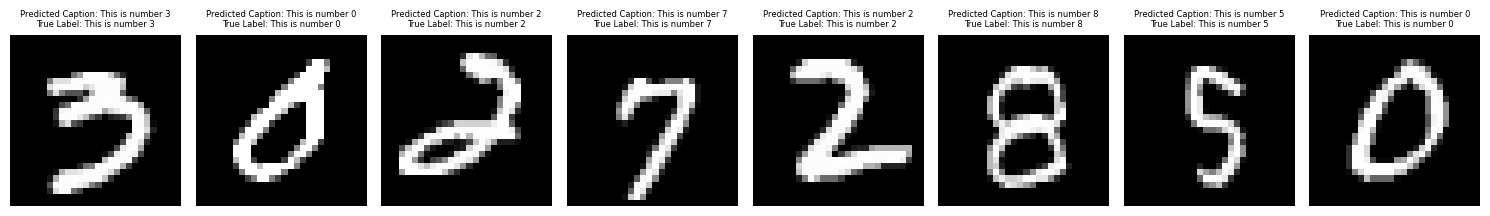

In [18]:
# Load the saved model for evaluation (replace "image_captioning_model_epoch.pth" with the correct filename if needed)
set_seed()
model.load_state_dict(torch.load("image_captioning_model_epoch.pth", weights_only=True))
evaluate_model(model, tokenizer, mnist_subset, num_of_eval_images=8)